In [1]:
import tensorflow as tf

from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
import sklearn.linear_model as lm
logreg = lm.LogisticRegression(multi_class='multinomial', solver='lbfgs')
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from numpy import dstack

import os
from functools import partial
from collections import namedtuple
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.9.2


In [6]:
pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

100% 1.76G/1.76G [00:56<00:00, 34.8MB/s]
100% 1.76G/1.76G [00:57<00:00, 33.1MB/s]


In [16]:
! unzip /content/lung-and-colon-cancer-histopathological-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc10.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc100.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1002.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1003.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1005.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1006.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1007.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1008.jpeg  
  inflating: lung_c

In [7]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sushantbehal","key":"3450328a7486662f8edfedd9932927ea"}'}

In [10]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [11]:
!cp kaggle.json ~/.kaggle/

In [12]:
! chmod 600 ~/.kaggle/kaggle.json

In [13]:
! kaggle datasets list

ref                                                           title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                     COVID-19 Dataset                                     5MB  2022-11-13 15:47:17          15624        441  1.0              
devrimtuner/list-of-moststreamed-songs-on-spotify             Top 100 Spotify Songs👑🎤🎧🎼                            3KB  2022-12-30 05:42:54            588         37  1.0              
thedevastator/analyzing-credit-card-spending-habits-in-india  Credit Card Spending Habits in India               319KB  2022-12-14 07:30:37           1837         61  1.0              
die9origephit/fifa-world-cup-2022-complete-dataset            Fifa World Cu

In [17]:
data_dir_train = pathlib.Path("/content/lung_colon_image_set/train")

data_dir_test = pathlib.Path('/content/lung_colon_image_set/test')

In [18]:
image_count_train = len(list(data_dir_train.glob('*/*')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*')))
print(image_count_test)

14988
15


In [19]:
batch_size = 32
img_height = 180
img_width = 180

In [40]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 14985 files belonging to 3 classes.
Using 11988 files for training.


In [41]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15 files belonging to 3 classes.
Using 3 files for validation.


In [39]:
!rmdir /content/lung_colon_image_set/test/.ipynb_checkpoints
!rmdir /content/lung_colon_image_set/train/.ipynb_checkpoints

rmdir: failed to remove '/content/lung_colon_image_set/test/.ipynb_checkpoints': No such file or directory


In [37]:
val_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [42]:
# List out all the classes of cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['lung_aca', 'lung_n', 'lung_scc']


<ipython-input-43-04a05c81fa7c>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3,5, i+1)


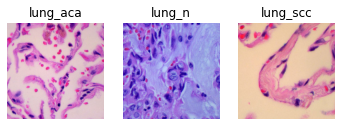

In [43]:
import matplotlib.pyplot as plt

### visualize training or validation data to 
plt.figure(figsize = (10,10))
for images, labels in train_ds.take(10):
  for i in range(3):
    ax = plt.subplot(3,5, i+1)
    plt.imshow(images[i].numpy().astype("int64"))
    plt.title(class_names[i])
    plt.axis("off")

In [44]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [45]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [46]:

image_size = 180

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(image_size, image_size),
  layers.experimental.preprocessing.Rescaling(1./255)
  #layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
])

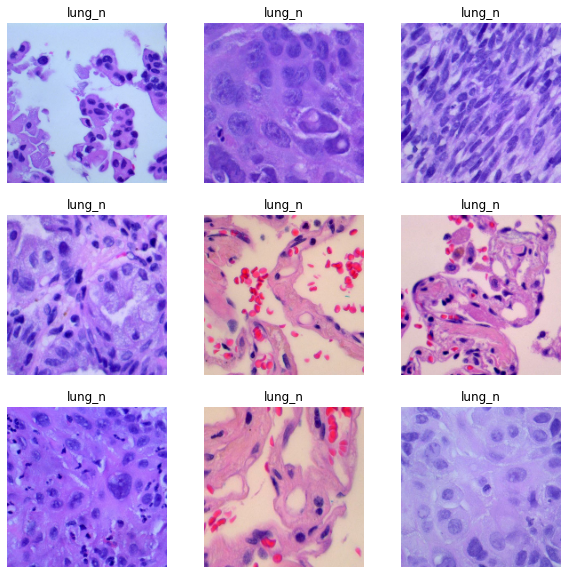

In [47]:
train_ds.take(1)
plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    
    plt.imshow(resize_and_rescale(images[i].numpy().astype("int64")))
    plt.title(class_names[1])
    plt.axis("off")

In [48]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names))
])

In [49]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [50]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
375/375 [==============================] - 9s 23ms/step - loss: 5.3228 - accuracy: 0.7837 - val_loss: 0.2621 - val_accuracy: 1.0000
Epoch 2/5
375/375 [==============================] - 9s 23ms/step - loss: 0.2545 - accuracy: 0.8979 - val_loss: 0.0723 - val_accuracy: 1.0000
Epoch 3/5
375/375 [==============================] - 8s 22ms/step - loss: 0.1793 - accuracy: 0.9309 - val_loss: 0.3704 - val_accuracy: 1.0000
Epoch 4/5
375/375 [==============================] - 9s 24ms/step - loss: 0.1150 - accuracy: 0.9590 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 5/5
375/375 [==============================] - 8s 22ms/step - loss: 0.0823 - accuracy: 0.9685 - val_loss: 0.2685 - val_accuracy: 0.6667


In [51]:
loss, acc = model.evaluate(val_ds)
print("Accuracy", acc)

1/1 [==============================] - 0s 10ms/step - loss: 0.2685 - accuracy: 0.6667
Accuracy 0.6666666865348816


In [52]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 22, 22, 64)      

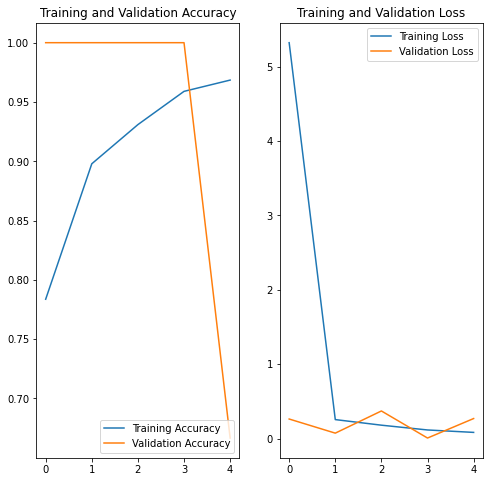

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [56]:
import pickle as pkl
pkl.dump(model, open('model.pkl', 'wb'))